In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

%matplotlib inline

# The 4 equations of the Hodgkin-Huxley model  

($V$: Membrane Potential)

* $C_M\displaystyle \frac{dV}{dt}=-g_{Na}\;\;(V-E_{Na})-g_k\;\;(V-E_K)-g_L\;\;(V-E_L)+I$   


($h$: Na Inactivation)  

* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}\;\;(1-h)-\beta_h(V)h$ 


($m$: Na Activation) 

* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}\;\;(1-m)-\beta_m(V)m$ 


($n$: K Activation)  

* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}\;\;(1-n)-\beta_n(V)n$ 

#### Task 1  

The Hodgkin Huxley class is already implemented, in a similar way as we implemented the LIF class in the previous exercises. 
Execute the cell below. This will run the function 'run_sim_and_show_lecture_plot()' that will generate the plot for the Hodgkin Huxley spike as you have seen in the lecture. 

Please go through the class and see whether the implementation makes sense to you
(it might make sense to start with the 'run_simulation' class and then move through the functions that are called). 
What are significant differences on the implementation level when you compare this class to the LIF class?


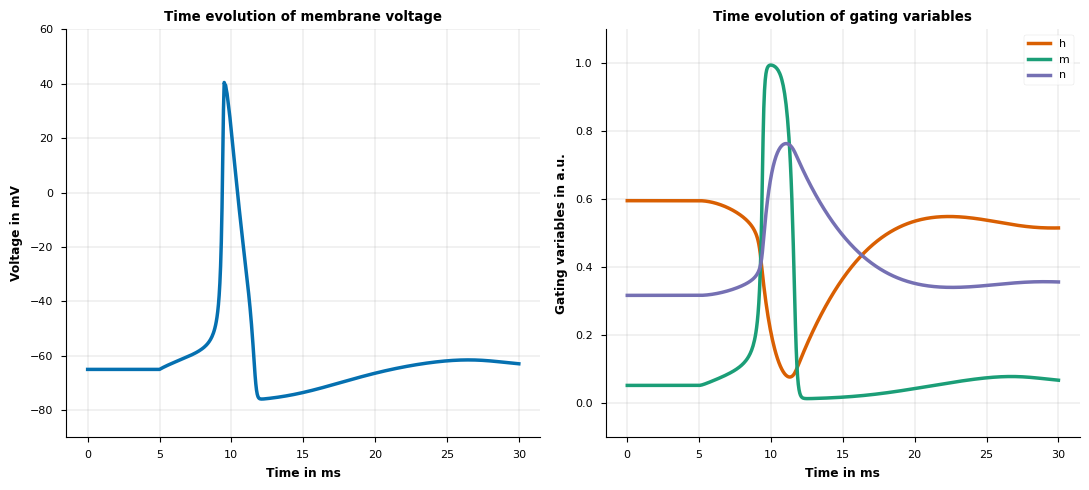

In [288]:
class HodgkinHuxleyNeuron(object):
    """A class to model the Hodgkin Huxley formalism for a spiking neuron
       The methods allow to run the simulation and plot the results
    """
    def __init__(self, 
                 g_na=120, # mS/cm2
                 g_k=36, # mS/cm2
                 g_l=0.3, # mS/cm2
                 e_na = 50, # mV
                 e_k  = -77, # mV
                 e_l  = -54.4, # mV
                 c_m = 1, # micro F/cm2
                 i_e = 0, # mu A /cm2,
                 dt = 0.05, # in ms
                ):
        '''This function is executed when we create an object from that class'''
        super(HodgkinHuxleyNeuron, self).__init__()

        ### assign the attributes of the class   
              
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep in ms    

        # maximum conductances
        self.g_na = g_na #g_na 
        self.g_k = g_k # g_k
        self.g_l = g_l # g_l
        
        # reveral potentials
        self.e_na = e_na # e_na
        self.e_k  = e_k # e_k
        self.e_l  = e_l # e_l
        
        # membrane capacitance
        self.c_m = c_m
        
        self.i_e = i_e # Input current        
        
        # initialize the gating parameters
        self.h = 0
        self.m = 0
        self.n = 0.5
        
        self.i_na = 0
        self.i_k = 0
        self.i_l = 0
        
        
        # initiate colors 
        self.color_h = '#D95F02'
        self.color_m = '#1B9E77'
        self.color_n = '#7570B3'
        
         # we need to run this function once to initilize the lists
        self.reset_lists()
        
        # when initiating, we run the model once, so that all the paramters (v, m, h, n)
        # settle in the steady state, then we reset the lists
        self.run_simulation(4000)
        self.reset_lists()
        
        
    def reset_lists(self):
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        self.m_list = [self.m]
        self.n_list = [self.n]
        self.h_list = [self.h]
        
        self.i_na_list = [self.i_na]
        self.i_k_list = [self.i_k]
        self.i_l_list = [self.i_l]
        
        self.i_e_list = [0]
        
        
        
    # define all the alpha and beta functions
    # this is simply the implementation of all the functions defined in the lecture
    def alpha_h(self, v):
        alpha_h = 0.07 * np.exp(-0.05*(v + 65))
        return alpha_h
    
    def beta_h(self, v):
        beta_h  = 1. / (1 + np.exp(-0.1*(v + 35)))
        return beta_h
    
    def alpha_m(self, v):
        alpha_m = 0.1 * (v + 40) / (1 - np.exp(-0.1*(v + 40)))
        return alpha_m
    
    def beta_m(self, v):
        beta_m  = 4. * np.exp(-0.0556*(v + 65))
        return beta_m
    
    def alpha_n(self, v):
        alpha_n = 0.01 * (v + 55) / (1-np.exp(-0.1*(v+55)))
        return alpha_n
    
    def beta_n(self, v):
        beta_n  = 0.125 * np.exp(-0.0125*(v + 65))
        return beta_n
    
        

    def delta_v(self):
        # the change for one timestep of V
        
        # we first calculate the currents through each channel type
        self.i_na = self.g_na * self.h * (self.m**3) * (self.v - self.e_na)
        self.i_k = self.g_k * (self.n**4) * (self.v - self.e_k)
        self.i_l = self.g_l * (self.v - self.e_l)
        
        delta_v = (- self.i_na - self.i_k - self.i_l + self.i_e) * self.dt / self.c_m
        
        return delta_v

    def delta_h(self):
        # the change for one timestep of h
        alpha = self.alpha_h(self.v)
        beta = self.beta_h(self.v)
        h = self.h
        delta_h = (alpha * (1 - h) - beta * h) * self.dt        
        return delta_h

    def delta_m(self):
        # the change for one timestep of m
        alpha = self.alpha_m(self.v)
        beta = self.beta_m(self.v)
        m = self.m
        delta_m = (alpha * (1 - m) - beta * m) * self.dt
        
        return delta_m

    def delta_n(self):
        # the change for one timestep of n
        alpha = self.alpha_n(self.v)
        beta = self.beta_n(self.v)
        n = self.n
        delta_n = (alpha * (1 - n) - beta * n) * self.dt
        
        return delta_n

    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        self.v += self.delta_v()
        self.h += self.delta_h()
        self.m += self.delta_m()
        self.n += self.delta_n()
        
        # append all the values to lists to save the data
        self.v_list.append(self.v)
        self.h_list.append(self.h)
        self.m_list.append(self.m)
        self.n_list.append(self.n)

        self.i_k_list.append(self.i_k)
        self.i_na_list.append(self.i_na)
        self.i_l_list.append(self.i_l)
        
        self.i_e_list.append(self.i_e)
        current_time = self.t_list[-1] + self.dt
        self.t_list.append(current_time) 


    def run_simulation(self, time_steps = 100, 
                        i_e_array = np.array([]), # we can provide an array for the input current. 
                         # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                         ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        for ii in range(time_steps):
            
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            self.timestep()
            
    def plot_voltage_and_gating(self):
        
        fig, axes = plt.subplots(1,2, figsize=(11,5))
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5, c='#0570B0')
        axes[1].plot(self.t_list,self.h_list,linewidth=2.5, label= 'h', c=self.color_h)
        axes[1].plot(self.t_list,self.m_list,linewidth=2.5, label= 'm', c =self.color_m)
        axes[1].plot(self.t_list,self.n_list,linewidth=2.5, label= 'n', c =self.color_n )

        axes[0].set(
            title = 'Time evolution of membrane voltage',
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV',
            ylim = [-90,60],
            )
        axes[1].set(
            title = 'Time evolution of gating variables',
            xlabel = 'Time in ms',
            ylabel = 'Gating variables in a.u.',
            ylim = [-0.1,1.1]
            )
        axes[1].legend()
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
        
    def plot_voltage_with_input_current(self):
        
        fig, axes = plt.subplots(2, figsize=(8,7))
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5, c='#0570B0')
        axes[1].plot(self.t_list,self.i_e_list,linewidth=2.5, label= 'input current', c=self.color_h)

        axes[0].set(
            title = 'Time evolution of membrane voltage',
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV',
            ylim = [-90,60],
            )
        axes[1].set(
            xlabel = 'Time in ms',
            ylabel = r'Input current in $\mu F/cm^2$ ',
            ylim = [-0.1,10],
            )
        axes[1].legend()
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
            
    def run_sim_and_show_lecture_plot(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        self.run_simulation(100)
        self.i_e = 3
        self.run_simulation(500)
        self.plot_voltage_and_gating()
        
        
    def show_steady_state_gating_and_time_constants(self):
        
        fig, axes = plt.subplots(1,2,figsize = (8,4))
        
        x = np.linspace(-110,70,1000)

        m_inf = self.alpha_m(x)/(self.alpha_m(x) + self.beta_m(x))
        h_inf = self.alpha_h(x)/(self.alpha_h(x) + self.beta_h(x))
        n_inf = self.alpha_n(x)/(self.alpha_n(x) + self.beta_n(x))
        axes[0].plot(x, m_inf, label=r'$m_{\infty}$',color=self.color_m)
        axes[0].plot(x, h_inf, label=r'$h_{\infty}$',color=self.color_h)
        axes[0].plot(x, n_inf, label=r'$n_{\infty}$',color=self.color_n)
        
        tau_m = 1/(self.alpha_m(x) + self.beta_m(x))
        tau_h = 1/(self.alpha_h(x) + self.beta_h(x))
        tau_n = 1/(self.alpha_n(x) + self.beta_n(x))
        axes[1].plot(x, tau_m, label=r'$\tau_m$',color=self.color_m)
        axes[1].plot(x, tau_h, label=r'$\tau_h$',color=self.color_h)
        axes[1].plot(x, tau_n, label=r'$\tau_n$',color=self.color_n)
        
        axes[0].set(
            title = 'steady state gating variables',
            xlabel = 'Membrane voltage in mV',
            ylabel = 'Open probability'
        )
        axes[1].set(
            title = 'gating time constants',
            xlabel = 'Membrane voltage in mV',
            ylabel = 'Open probability'
        )
        
        axes[0].legend()
        axes[1].legend()

        
model_lecture = HodgkinHuxleyNeuron()
model_lecture.run_sim_and_show_lecture_plot()


There are some methods already included in the class. One you already used above, they are included in the method run_sim_and_show_lecture_plot() : 

When you created a model like for example

```python
example_model = HodgkinHuxleyNeuron()
```
you can use the same mehtod you are used to from the LIF model class to run the simulation 
```python
example_model.run_simulation(time_steps = 200)
```

Once the simulatin is run, you can show the results with two possible methods. 
1)
```python
example_model.plot_voltage_and_gating()
```
will create a figure that contains the voltage trace on the left and the dynamics of the gating variables on the right.
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/example_voltage_and_gating.png" width="650"/>
</div>


The second one:
```python
example_model.plot_voltage_and_gating()
```
will show you the voltage trace combined with the input current that has been induced over the simulation. 
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/example_voltage_and_input.png" width="650"/>
</div>


The method 
```python
example_model.show_steady_state_gating_and_time_constants()
```
is independent of a run and calculates (using alpha and beta as defined in the class) the steady state gating variables and time constants and shows them in a plot. 
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/steady_state_gating_and_time_constants.png" width="650"/>
</div>



As you can see in the method
```python 
def run_sim_and_show_lecture_plot(self):
    '''
        Function to plot the simulated results
        creates a figure and plots the voltage traces vs. the simulated time
    '''

    self.run_simulation(100)
    self.i_e = 3
    self.run_simulation(500)
    self.plot_voltage_and_gating()
```

you can change the input current $i_e$ in between runs as we did before with the LIF model class. 
However, for more complex input patterns I now added another possibility. 

We now use numpy arrays for this (they behave in many ways like lists). You can generate the same output as with the above method now with the following implementation:

```python

sim_len = 600

i_e = np.zeros(sim_len) 
# making the array the same lenght as the simulation ensures that it behaves like we plan to
i_e[100:] = 3
self.run_simulation(sim_len)
self.plot_voltage_and_gating()

```


For the following tasks you can now use these functions, or you can write your own code. 
Remember that you can always access the attributes of a class 

when you are writing a method (a function that belongs to the class)
```python
def example_method(self):
    
    example_attribute = self.t_list
    
```

or when you are accessing them outside the class
```python
example_object = HodgkinHuxleyNeuron()
example_attribute = example_object.t_list
```


this allows you for example to make different instancens of the HodgkinHuxleyNeuron class with different parameters and show the results in the same figure (and idea that might help for task 3 and following)



### Task 2

Above and in the lecture we have induced a current into the neuron model and have seen a spike in response. Can you implement a run that also induces a current but there is no spike? 
Can you think of distinct ways of **not** inducing a spike with a current?

What do you observe in the membrane potential even if there is no spike?

### [Solution 2](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/0b6d6a1ac53626e00xdee2ae7ca5b425.txt)

#### Task 3

We now want to investigate the effect of different maximum conudctance strenghts for the Na channel (g_na)

Create a plot that shows the voltage trace given a steady input current of i_e = 3 $\mu F/cm^2$ for the different maximum conductance values g_na in of 80, 100, 120 & 140. 

What happens with the action potential, did you expect that? 


### [Solution 3](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e930103b430326b69fb0b4d6c8c80217.txt)

#### Task 4

We now want to investigate the effect of different maximum conudctance strenghts for the K channel (g_k)

Create a plot that shows the voltage trace given a steady input current of i_e = 3 $\mu F/cm^2$ for the different maximum conductance values g_k in of 20, 30, 40 & 50. 

What happens with the action potential, did you expect that? 

### [Solution 4](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e9301038090326b69fb0b4d6c8c80fb2.txt)

### Task 5

We now want to investigate the refractory period of the Hodgkin Huxley neuron, i.e. the time after a spike, where no other spike can happen, even if there is input. 
Can you think about an input pattern that would illustrate this behavior? 

Draw your idea (how should the input current and the corresponding voltage trace look like?) on a paper or in digital form before proceeding to the implementation.

### [Solution 5](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e9314538090326b69bbbb4d6c8c80217.txt)

### Taks 6

Implement your idea ( or the idea presented in solution 5) of how to illustrate the refractory period


### [Solution 6](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e9314538090326b69fb0b4d6c8c80217.txt)

### Task 7 

We now come back to our LIF model. 
belwo you seethe class we developed in the last session (slightly adapted, so that it can now also take on more complex input patterns with an input array). 

run the cell below to create the class and make sure that you understand the code (again).
There are two slight changes:

1) there is an actual spike implemented (the membrane potential is set to 40 mV for one time step when the threshold is crossed

2) there is a refractory period after each spike, within which the membrane potential is kept constant

In [352]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -70, refrac_time = 10, v_th = -50, e_l = -75, i_e = 0, dt = 0.05,
                 g_ampa = 0, g_gaba = 0,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        ''' refractory period '''
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        ''' refractory period '''
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt

        
        
            
        ### Time evolution of the membrane potential
        
        
        ''' refractory period '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            
        
        else:
            i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
            i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)



            ### Time evolution of the membrane potential
            if self.v <= self.v_th:
                dv_dt = (-self.v + self.e_l + self.r_m * self.i_e + self.r_m*i_ampa + self.r_m*i_gaba )/self.tau_m
                self.v += dv_dt * self.dt
            else:
                # here we implement a spiking behavior (mainly just for the look)
                if self.v != 40:
                    self.v = 40
                else:
                    self.v = self.v_reset
                    self.refrac_tracker = self.refrac_time
                
                
                
        self.v_list.append(self.v)
        current_time = self.t_list[-1] + self.dt
        self.t_list.append(current_time) 
        self.i_e_list.append(self.i_e)


    def run_simulation(self, time_steps = 100, i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''

        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
            
            
            self.timestep()

### Task 8 

Your task is now to fit the output of the LIF model to the output of the Hodgkin Huxley model. 

You can use the interactive tool below to search for the best fit. 
The parameters that you can change from the LIF model are

c_m, the specific capacitance of the membrane
r_m, the specific resistance of the membrane 
together, these two will give you tau_m , the time constant. 

refrac_time, the refractory period in ms 
e_l, the leak reversal potential

When you think that you found a good fit, let me know the parameters. 

In [394]:

def test(c_m = 1.5, r_m = 3, refrac_time = 4, e_l = -70, v_th = -51):
    
    sim_len = 1000

    I_input = np.zeros(sim_len)
    I_input[100:600] = 8

    lif_model = LIFNeuron(c_m=c_m, r_m = r_m, refrac_time = refrac_time, e_l = e_l, v_th = v_th)
    hh_model = HodgkinHuxleyNeuron()

    lif_model.run_simulation(sim_len, i_e_array = I_input)
    hh_model.run_simulation(sim_len, i_e_array = I_input)


    fig, axes = plt.subplots(2)
    axes[0].plot(hh_model.t_list, hh_model.v_list, label='Hodgin Huxley')
    axes[0].plot(lif_model.t_list, lif_model.v_list, label = 'LIF')
    
    axes[1].plot(hh_model.t_list, hh_model.i_e_list, label='Hodgin Huxley')
    axes[1].plot(lif_model.t_list, lif_model.i_e_list, label = 'LIF')

    axes[0].set(
        xlabel='time in ms',
        ylabel='Membrane voltage in mV',
        ylim = [-80,50]
    )
    
    axes[1].set(
        xlabel = 'Time in ms',
        ylabel='Input current in $\mu F/cm^2$',
         ylim = [-0.1,10]
    )
    
    axes[0].legend()
    axes[1].legend()

widgets.interact(test, 
                 c_m = (0.01, 5,0.01), 
                 r_m = (0.1,20,0.2), 
                 refrac_time=(1,20,0.2), 
                 e_l = (-80,-60,0.2),
                 v_th = (-60,-40,0.2))

interactive(children=(FloatSlider(value=1.5, description='c_m', max=5.0, min=0.01, step=0.01), FloatSlider(val…

<function __main__.test(c_m=1.5, r_m=3, refrac_time=4, e_l=-70, v_th=-51)>

### Synaptic inputs

We now add synaptic inputs to our Hodgkin Huxley class.
We also now use the idea of parent and child classes. 
Our new class will basially inherit all the attributes and methods from the class we defined at the beginning. 
if we add a method to this child class that has the same name as a method in the parent class, we overwrite that method. 

it is not important for now to understand how the inheritance works. 
We could have achieved the exact same solution by copying the old class and addig in the lines for the synaptic inputs.

In [340]:
class HodgkinHuxleyNeuron_AmpaGaba(HodgkinHuxleyNeuron):
    """A class to model the Hodgkin Huxley formalism for a spiking neuron
       The methods allow to run the simulation and plot the results
    """
    def __init__(self, 
                 g_na=120, # mS/cm2
                 g_k=36, # mS/cm2
                 g_l=0.3, # mS/cm2
                 e_na = 50, # mV
                 e_k  = -77, # mV
                 e_l  = -54.4, # mV
                 c_m = 1, # micro F/cm2
                 i_e = 0, # mu A /cm2,
                 dt = 0.05, # in ms,
                 g_ampa = 0,
                 g_gaba = 0,
                ):
        '''This function is executed when we create an object from that class'''
        
        
        # we first define the synaptic parameters
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        
        ''' Then, we call the init function from the parent class 
            HodgkinHuxleyNeuron and pass the parameters'''        
        
        super(HodgkinHuxleyNeuron_AmpaGaba, self).__init__(
             g_na=g_na,
             g_k=g_k,
             g_l=g_l, 
             e_na = e_na,
             e_k = e_k,
             e_l  = e_l,
             c_m = c_m,
             i_e = i_e, 
             dt = dt,        
        )

        
        
        

    ''' in addition to the init method, we also have to change the delta_v method '''
    def delta_v(self):
        # the change for one timestep of V        
        
        # we first calculate the currents through each channel type
        self.i_na = self.g_na * self.h * (self.m**3) * (self.v - self.e_na)
        self.i_k = self.g_k * (self.n**4) * (self.v - self.e_k)
        self.i_l = self.g_l * (self.v - self.e_l)
        
        i_ampa = self.g_ampa*self.ps_ampa*(self.v-self.e_ampa)
        i_gaba = self.g_gaba*self.ps_gaba*(self.v-self.e_gaba)
        
        delta_v = (- self.i_na - self.i_k - self.i_l + self.i_e - i_gaba - i_ampa) * self.dt / self.c_m
        
        return delta_v


    ''' and we have to overwrite the timestep function '''
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt
        
        
        
        self.v += self.delta_v()
        self.h += self.delta_h()
        self.m += self.delta_m()
        self.n += self.delta_n()
        
        # append all the values to lists to save the data
        self.v_list.append(self.v)
        self.h_list.append(self.h)
        self.m_list.append(self.m)
        self.n_list.append(self.n)

        self.i_k_list.append(self.i_k)
        self.i_na_list.append(self.i_na)
        self.i_l_list.append(self.i_l)
        
        self.i_e_list.append(self.i_e)
        current_time = self.t_list[-1] + self.dt
        self.t_list.append(current_time) 

### Task 9 

run the cell below. This is the same widget we already had for the LIF model, now for the HH model.

In [366]:
def run_and_plot(I_e, gaba_input_timestep):
    neuron = HodgkinHuxleyNeuron_AmpaGaba(g_ampa = 0.08, g_gaba = 0.6)
    ampa_inputs = [1000, 1050, 1100]   
    gaba_inputs = [gaba_input_timestep]
    for ii in range(2000):
        # we can check whether our current timestep is in the list of inputs we provide
        if ii in ampa_inputs:
            neuron.ampa_input = True

        if ii in gaba_inputs:
            neuron.gaba_input = True

        neuron.timestep()
                       
    plt.figure()
    plt.title('Time evolution of membrane voltage')

    plt.plot(neuron.t_list,neuron.v_list,linewidth=2.5)

    plt.xlabel('Time in ms')
    plt.ylabel('Voltage in mV')

    plt.ylim([-85,50])
    
    
    # reading out the time and voltage value so that the arrow points to the plot
    # If you don't know how to access an element in the list, feel free to ask
    x_input = neuron.t_list[gaba_input_timestep] 
    y_input = neuron.v_list[gaba_input_timestep]
    
    # use the annotate function to plot an arrow and the text 'GABA input'
    plt.annotate('GABA input', xy =(x_input, y_input),
                xytext =(x_input-40, y_input + 20), 
                arrowprops = dict(arrowstyle='->',facecolor ='#CC1414', edgecolor='#CC1414',
                                  shrinkA = 0.1))

widgets.interact(run_and_plot,I_e = 5, gaba_input_timestep=(700,1150,10))

interactive(children=(IntSlider(value=5, description='I_e', max=15, min=-5), IntSlider(value=920, description=…

<function __main__.run_and_plot(I_e, gaba_input_timestep)>

### Task 10

Now instead of a constant current as in task 8, we add more complex synaptic input patterns.
Can you use the same paramters that you found in task 8 to fit the LIF model to the HH model?

In [395]:
def run_input_simulation(model, 
                   time_steps = 100,
                   ampa_inputs = [],
                   gaba_inputs = [],
                  i_e_array = np.array([])):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                model.i_e = i_e_array[ii]            
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                model.ampa_input = True
            
            if ii in gaba_inputs:
                model.gaba_input = True
            
            model.timestep()

            
def test(c_m = 1.5, r_m = 3, refrac_time = 4, e_l = -70, v_th = -51):
    
    sim_len = 1000

    ampa_inputs = [100,110,120,160,170,220,240,280,500,520,560]
    gaba_inputs = [20,90,130,180,250,280,480,510,570]

    lif_model = LIFNeuron(c_m=c_m, r_m = r_m, refrac_time = refrac_time, e_l = e_l, v_th = v_th,
                         g_ampa = 8e-2, g_gaba = 12e-2)
    hh_model = HodgkinHuxleyNeuron_AmpaGaba(g_ampa = 8e-2, g_gaba=1.8e-1)
#     hh_model = HodgkinHuxleyNeuron()

    run_input_simulation(lif_model, time_steps = sim_len, 
                         ampa_inputs = ampa_inputs,
                        gaba_inputs = gaba_inputs)
    run_input_simulation(hh_model, time_steps = sim_len, 
                         ampa_inputs = ampa_inputs,
                        gaba_inputs = gaba_inputs)


    fig, axes = plt.subplots(2)
    axes[0].plot(hh_model.t_list, hh_model.v_list, label='Hodgin Huxley')
    axes[0].plot(lif_model.t_list, lif_model.v_list, label = 'LIF')

    axes[0].set(
        xlabel='time in ms',
        ylabel='Membrane voltage in mV',
        ylim = [-80,50]
    )
    
    
    axes[0].legend()

widgets.interact(test, 
                 c_m = (0.01, 5,0.01), 
                 r_m = (0.1,20,0.2), 
                 refrac_time=(1,20,0.2), 
                 e_l = (-80,-60,0.2),
                 v_th = (-60,-40,0.2))




interactive(children=(FloatSlider(value=1.5, description='c_m', max=5.0, min=0.01, step=0.01), FloatSlider(val…

<function __main__.test(c_m=1.5, r_m=3, refrac_time=4, e_l=-70, v_th=-51)>